<a href="https://colab.research.google.com/github/Tonathiu-Pina/Solver-Navier-Stokes-and-advection-convection-equations/blob/main/NS_AC_Aco_Impli_no_GLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Read me

In [ ]:
%%capture
"""
Created on Sat May 11 00:40:05 2024

@author: user

    Resuelve las eccuaciones de Navier-Stokes y las de Advección-Convección
    Es Acoplado ya que en cada instante de tiempo que resueve la vel. de N-S
resuelve la ecuación de trasnporte
    La ec. de A-C es resuelta con un esquema implicito
    No presenta ningun estabilizador

"""

#Set up

##Packages

In [ ]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

!pip install pdf2image imageio
!apt-get install -y poppler-utils

In [ ]:
import os
import re
import math
import gdown
import shutil
import imageio
import numpy as np
from fenics import *
import fenics as fe
from tqdm import tqdm  # optional
from google.colab import files
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from scipy.optimize import curve_fit
from pdf2image import convert_from_path


##Funtions

In [ ]:
def path(dirs):
  """
  Crea las carpetas temporales donde se guardara la solución
  """


  for dir in dirs:
    os.makedirs(dir, exist_ok=True)
  print("Paths have been created")

def coeficiente_de_difusividad():
  print('Ingresa el valor del coeficiente de difusivadad que quieres usar:\nBase: 6\nNewton: 3.55e-9\nChang: 7.97e-8')
  coeficiente = input().lower()
  if coeficiente == 'base':
    D = 6
  if coeficiente == 'newton':
    D = 3.55e-9
  if coeficiente == 'chang':
    D = 7.97e-8
  print('Constante de difusividad elegido:\n', coeficiente,'\n',D)
  return D

def load_mesh(file_id):
  """
  Carga el xml principal de la malla
  El file_id debe ser de un link al que todos pueda tener acceso
  """

  url = f"https://drive.google.com/uc?id={file_id}"

  output = 'downloaded_file.xml'
  gdown.download(url, output, quiet=False)


  mesh = fe.Mesh(output)

  V = fe.FunctionSpace(mesh, 'CG', 1)
  u = fe.Function(V)

  plot(mesh)
  plt.show()
  return mesh

def load_boundaries(file_id,mesh):
  """
  Carga el facet_region de la malla
  El file_id debe ser de un link al que todos pueda tener acceso
  Revisar que si se este cargando el facet_region y no el physical_region
  """

  url = f"https://drive.google.com/uc?id={file_id}"

  output = 'downloaded_file.xml'
  gdown.download(url, output, quiet=False)


  boundaries = fe.MeshFunction('size_t', mesh, output)
  return boundaries



def natural_key(text):
  #Ordena numericamente los archivos de una carpeta
    return [int(part) if part.isdigit() else part for part in re.split(r'(\d+)', text)]

def clean(dirs):
  """
  Elimina los archivos de las soluciones
  """
  print("Esta celda es para limpiar las carpteas delas soluciones")
  print("¿Estas seguro que quiere borras las capetas con las soluciones? (Y/N)")
  respuesta=input().upper()

  if respuesta == 'Y':
    print("Pregunto otra vez\n¿Estas seguro que quiere borras las capetas con las soluciones? (Y/N)")
    respuesta=input().upper()
    if respuesta == 'Y':
      for dir in dirs:
        shutil.rmtree(dir)
      print("Se borro todo\nLo hecho, hecho está")
  else:
    print("Nada se borro")
  path(dirs)



def plot_results(m,n,plotting_enabled,u_next,c_next,p_next):
    """
    m: Indica cada cuantos pasos de tiempo genera la grafica (m<<n) {depreferencia elegir un numero par}
    n=n: Numero de iteración del ciclo temporal
    plotting_enabled: tipo de ploteo, sencillo (2 graficas) completo (4 graficas) (0,1) {Entrada binaria}
    u_next,c_next,p_next: Solución a graficar
    """


    if n % m == 0:
        simulation_instant = int(SIMULATION_TIME * n / N_TIME_STEPS)

        if plotting_enabled == 0:
            # Visualize interactively
            #vtkfile = File('field_of_velocity/' + f'field_of_velocity {simulation_instant}s.pvd')
            filename = os.path.join(field_dir,f'field_of_velocity {simulation_instant}s.pdf')
            plt.figure(1)
            cu_n = fe.plot(u_next, title=f'field of velocity {simulation_instant}s')
            plt.colorbar(cu_n)
            plt.draw()
            #vtkfile << u_next
            plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
            plt.clf()

            #vtkfile = File('Pollution/' + f'Pollution {simulation_instant}s.pvd')
            filename = os.path.join(pullution_dir, f'Pollution {simulation_instant}s.pdf')
            plt.figure(2)
            cc_n = fe.plot(c_next, title=f'Pollution {simulation_instant}s')
            plt.colorbar(cc_n)
            plt.draw()
            #vtkfile << c_next
            plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
            plt.clf()

        if plotting_enabled == 1:
            # Plot solutions
            filename = os.path.join(field_dir,f'field_of_velocity {simulation_instant}s.pdf')
            plt.figure(1)
            cu = fe.plot(u_next, title=f'field of velocity {simulation_instant}s')
            plt.colorbar(cu)
            plt.draw()
            plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
            plt.clf()

            filename = os.path.join(velocity_dir,f'velocity {simulation_instant}s.pdf')
            plt.figure(2)
            cu_norm = fe.plot(sqrt(dot(u_next, u_next)), title=f'velocity {simulation_instant}s')
            plt.colorbar(cu_norm)
            plt.draw()
            plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
            plt.clf()

            filename = os.path.join(pressure_dir,f'pressure {simulation_instant}s.pdf')
            plt.figure(3)
            cps = plot(p_next, mode='color', title=f'pressure {simulation_instant}s')
            plt.colorbar(cps)
            plt.draw()
            plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
            plt.clf()

            filename = os.path.join(pullution_dir,f'Pollution {simulation_instant}s.pdf')
            plt.figure(4)
            cc_n = fe.plot(c_next, title=f'Pollution {simulation_instant}s')
            plt.colorbar(cc_n)
            plt.draw()
            plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
            plt.clf()

def pdf2gif(dir,time):
  """
  dir:Directorio de la carpeta a comprimir y descargar
  time:Diración del
  """
  gif_output_path=dir+'/'+dir[9:]+'.gif'


  # Obtener y ordenar los archivos PDF en orden natural
  pdf_files = sorted([f for f in os.listdir(dir) if f.endswith('.pdf')], key=natural_key)


  images = []
  # Convertir cada PDF a imágenes
  for pdf_file in pdf_files:
    if pdf_file.endswith('.pdf'):
      pdf_path = os.path.join(dir, pdf_file)
      pages = convert_from_path(pdf_path)
      for page in pages:
        images.append(page)

  # Guardar las imágenes en archivos temporales
  temp_image_files = []
  for i, image in enumerate(images):
    temp_image_file = os.path.join(dir, f'temp_image_{i}.png')
    image.save(temp_image_file, 'PNG')
    temp_image_files.append(temp_image_file)

      # Crear el GIF
  with imageio.get_writer(gif_output_path, mode='I', duration=time, loop=0) as writer:
    for temp_image_file in temp_image_files:
      image = imageio.imread(temp_image_file)
      writer.append_data(image)
    print(f'GIF creado en {gif_output_path}')

  for temp_image_file in temp_image_files:
    os.remove(temp_image_file)

def descarga_soluciones(dir):
  """
  dir:Directorio de la carpeta a comprimir y descargar
  """
  zip_filename = dir + ".zip"
  shutil.make_archive(dir, 'zip', dir)
  print(f"Archivo zip creado: {zip_filename}")

  # Descargar el archivo zip

  files.download(zip_filename)

#Paths

In [ ]:
field_dir="/content/field_of_velocity"
velocity_dir="/content/velocity"
pressure_dir="/content/pressure"
pullution_dir="/content/Pollution"
dirs=[field_dir,velocity_dir,pressure_dir,pullution_dir]

In [ ]:
path(dirs)

Paths have been created


#Physical Parameters

In [ ]:
# Define time step
TIME_STEP_LENGTH = 0.5
NUM_HOURS = 0.5
SIMULATION_TIME = NUM_HOURS * 3600 #seg
print('simulation time (seg):',SIMULATION_TIME)
N_TIME_STEPS = int(SIMULATION_TIME / TIME_STEP_LENGTH)
t = np.linspace(0, SIMULATION_TIME, N_TIME_STEPS)

rho = 997     # Densidad del agua             (kg/m³)
eta = 0.001   # Viscozidad dinamica del agua  (Pa*s)

D = 60 #coeficiente_de_difusividad()  # Coeficiente de difusividad     (m²/s)

epsilon = Constant(0.0)   # Coeficiente de reactividad



simulation time (seg): 1800.0


In [ ]:
def load_mesh_v2(file_id):
  """
  Carga el xml principal de la malla
  El file_id debe ser de un link al que todos pueda tener acceso
  """

  url = f"https://drive.google.com/uc?id={file_id}"

  output = 'downloaded_file.xml'
  gdown.download(url, output, quiet=False)


  mesh = fe.Mesh(output)

  V = fe.FunctionSpace(mesh, 'CG', 1)
  u = fe.Function(V)

  plot(mesh)
  plt.savefig('mesh.pdf', bbox_inches='tight', pad_inches=0.1)
  plt.show()

  return mesh

Downloading...
From (original): https://drive.google.com/uc?id=1OUGc0O-2KJwdO_Pnu18RBdYck6mzlm0a
From (redirected): https://drive.google.com/uc?id=1OUGc0O-2KJwdO_Pnu18RBdYck6mzlm0a&confirm=t&uuid=a48c2e23-e2b2-4150-8e61-3a924aa7c11a
To: /content/downloaded_file.xml
100%|██████████| 1.42M/1.42M [00:00<00:00, 100MB/s]


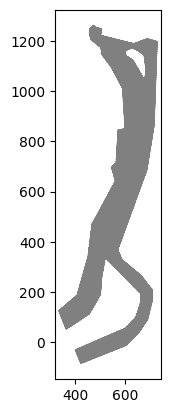

In [ ]:
malla_xml_id='1OUGc0O-2KJwdO_Pnu18RBdYck6mzlm0a'
boundaries_xml_id='1lA1YXFaElkXs7SSx--yImR5rlu9Aqyc0'


mesh=load_mesh_v2(malla_xml_id)

# **SOLVER**

Downloading...
From (original): https://drive.google.com/uc?id=1OUGc0O-2KJwdO_Pnu18RBdYck6mzlm0a
From (redirected): https://drive.google.com/uc?id=1OUGc0O-2KJwdO_Pnu18RBdYck6mzlm0a&confirm=t&uuid=c7e88cba-aa80-4024-85fa-4a1d5cc0ebcf
To: /content/downloaded_file.xml
100%|██████████| 1.42M/1.42M [00:00<00:00, 56.9MB/s]
Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00619316 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC

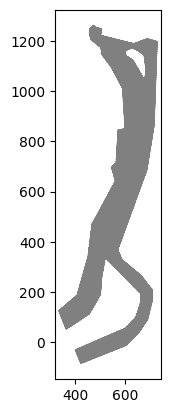

Downloading...
From (original): https://drive.google.com/uc?id=1lA1YXFaElkXs7SSx--yImR5rlu9Aqyc0
From (redirected): https://drive.google.com/uc?id=1lA1YXFaElkXs7SSx--yImR5rlu9Aqyc0&confirm=t&uuid=a59c41a1-0aa8-47d0-8ab4-6a1597eae8ad
To: /content/downloaded_file.xml
100%|██████████| 683k/683k [00:00<00:00, 43.5MB/s]
Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f4c31f6e8b0e7ddceb14ce599aa08d063c1bdf82

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00458455 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:

In [ ]:
def main():
    # Extract mesh data
    """
    malla_xml_id,boundaries_xml_id: El el file_ID del link de drive
    El link debe ser poder editador por todo el publico
    file_ID se encuentra en el link, entre: /d/ y /view?
    """

    #malla_xml_id='1pS91IZdgcips7xqwd1N2JcstDhOlr4DK'
    #boundaries_xml_id='1lA1YXFaElkXs7SSx--yImR5rlu9Aqyc0

    malla_xml_id='1OUGc0O-2KJwdO_Pnu18RBdYck6mzlm0a'
    boundaries_xml_id='1lA1YXFaElkXs7SSx--yImR5rlu9Aqyc0'


    mesh=load_mesh(malla_xml_id)
    boundaries = load_boundaries(boundaries_xml_id,mesh)



    # Define functions space
    velocity_function_space = fe.VectorFunctionSpace(mesh, "CG", 2)
    pressure_function_space = fe.FunctionSpace(mesh, "CG", 1)
    pollution_function_space = fe.FunctionSpace(mesh, "CG", 1)

    # Define the Initial Value
    u_0 = fe.Expression(('0.0', '0.0'), degree=2) #velocity in walls
    c_0 = fe.Expression('5*cos( 2*pi/27* ( x[0] - 399) ) + 6', pi=math.pi ,degree=2) #Constant(50.0)
    c_0_2 = Constant(0.5)
    c_river = Constant(1.0)

    # Define the Boundary Condition for velocity
    u_inflow = fe.Expression(('1.86', '0.73'), degree=2)
    u_in_boundary_condition = fe.DirichletBC(
        velocity_function_space,
        u_inflow,
        boundaries,
        1   #In
    )
    u_wall_boundary_condition = fe.DirichletBC(
        velocity_function_space,
        u_0,
        boundaries,
        2 #Wall
    )

    # Define the Boundary Condition for pressure
    p_out_boundary_condition = fe.DirichletBC(
        pressure_function_space,
        Constant(0.0),
        boundaries,
        3 #Out
    )

    # Define the Boundary Condition for pollution (Contaminación)
    c_in_boundary_condition = fe.DirichletBC(
        pollution_function_space,
        c_0,
        boundaries,
        1 #in
    )

    # Define the Boundary Condition for NO_pollution (Contaminación)
    c_in_boundary_condition_2 = fe.DirichletBC(
        pollution_function_space,
        c_0_2,
        boundaries,
        1 #in
    )


    velocity_boundary_conditions = [u_in_boundary_condition, u_wall_boundary_condition]
    pressure_boundary_conditions = [p_out_boundary_condition]
    pollution_boundary_conditions = [c_in_boundary_condition]
    pollution_boundary_conditions_2 = [c_in_boundary_condition_2]

    # Sourse Pollution

    #pollution_sourse = Constant(10) (Al aplicar la condición de frontera de forma numerica, en la frontera simpre hay la misma cantidad de contaminación)

    # Define trial functions
    u_trial = fe.TrialFunction(velocity_function_space)
    p_trial = fe.TrialFunction(pressure_function_space)
    c_trial = fe.TrialFunction(pollution_function_space)

    # Define test functions
    v_test = fe.TestFunction(velocity_function_space)
    q_test = fe.TestFunction(pressure_function_space)
    c_test = fe.TestFunction(pollution_function_space)

    # Define the solution fields involved
    u_tent = fe.Function(velocity_function_space)
    u_next = fe.Function(velocity_function_space)
    p_next = fe.Function(pressure_function_space)
    c_next = fe.Function(pollution_function_space)

    # Define functions for quantities at previous time
    u_prev = fe.interpolate(u_0, velocity_function_space)
    c_prev = fe.interpolate(c_river, pollution_function_space)

    # Weak form of the momentum equation
    momentum_weak_form_residuum = (
            rho *(1.0 / TIME_STEP_LENGTH) * fe.dot((u_trial - u_prev), v_test) * fe.dx
            +
            rho *fe.dot(fe.dot(u_prev, fe.nabla_grad(u_trial)), v_test) * fe.dx
            +
            eta * fe.inner(nabla_grad(u_trial), fe.nabla_grad(v_test)) * fe.dx
    )

    momentum_weak_form_lhs = fe.lhs(momentum_weak_form_residuum)
    momentum_weak_form_rhs = fe.rhs(momentum_weak_form_residuum)

    # Weak form of the pressure poisson problem
    pressure_poisson_weak_form_lhs = fe.dot(fe.grad(p_trial), fe.grad(q_test)) * fe.dx
    pressure_poisson_weak_form_rhs = - rho / TIME_STEP_LENGTH * fe.dot(fe.div(u_tent), q_test) * fe.dx

    # Weak form of the velocity update equation
    velocity_update_weak_form_lhs = rho * fe.dot(u_trial, v_test) * fe.dx
    velocity_update_weak_form_rhs = (
            rho * fe.dot(u_tent, v_test) * fe.dx
            -
            TIME_STEP_LENGTH * fe.inner(fe.grad(p_next), v_test) * fe.dx
    )

    # Weak form of the pollution transport problem
    pollutions_weak_form=(
        1/TIME_STEP_LENGTH *fe.dot((c_trial-c_prev),c_test) * fe.dx
        +
        fe.inner( fe.dot(u_next, fe.grad(c_trial)),c_test) * fe.dx
        +
        D*fe.inner(nabla_grad(c_trial), fe.nabla_grad(c_test)) * fe.dx
        +
        epsilon * c_trial * c_test * fe.dx
        )

    pollutions_trasnport_weak_form_lhs = fe.lhs(pollutions_weak_form)
    pollutions_trasnport_weak_form_rhs = fe.rhs(pollutions_weak_form)



    # Pre-Compute the system matrices (because they do not greatly change)
    momentum_assembled_system_matrix = fe.assemble(momentum_weak_form_lhs)
    pressure_poisson_assembled_system_matrix = fe.assemble(pressure_poisson_weak_form_lhs)
    velocity_update_assembled_system_matrix = fe.assemble(velocity_update_weak_form_lhs)
    pollution_update_assembled_system_matrix = fe.assemble(pollutions_trasnport_weak_form_lhs)


    for n in tqdm(range(N_TIME_STEPS)):

        # (1) Solve for tentative velocity
        momentum_assembled_rhs = fe.assemble(momentum_weak_form_rhs)
        [bc.apply(momentum_assembled_system_matrix, momentum_assembled_rhs) for bc in velocity_boundary_conditions]
        fe.solve(
            momentum_assembled_system_matrix,
            u_tent.vector(),
            momentum_assembled_rhs,
            "gmres",
            "ilu",
        )

        # (2) Solve for the pressure
        pressure_poisson_assembled_rhs = fe.assemble(pressure_poisson_weak_form_rhs)
        [bc.apply(pressure_poisson_assembled_system_matrix, pressure_poisson_assembled_rhs) for bc in
         pressure_boundary_conditions]
        fe.solve(
            pressure_poisson_assembled_system_matrix,
            p_next.vector(),
            pressure_poisson_assembled_rhs,
            "gmres",
            "amg",
        )

        # (3) Correct the velocities to be incompressible
        velocity_update_assembled_rhs = fe.assemble(velocity_update_weak_form_rhs)
        # [bc.apply(velocity_update_assembled_system_matrix, velocity_update_assembled_rhs) for bc in velocity_boundary_conditions]
        fe.solve(
            velocity_update_assembled_system_matrix,
            u_next.vector(),
            velocity_update_assembled_rhs,
            "gmres",
            "ilu",
        )
        if n < N_TIME_STEPS*0.1:
          ## (4) Solve for the pollution
          pollutions_trasnport_assembled_rhs = fe.assemble(pollutions_trasnport_weak_form_rhs)
          [bc.apply(pollution_update_assembled_system_matrix, pollutions_trasnport_assembled_rhs) for bc in pollution_boundary_conditions]
          fe.solve(
              pollution_update_assembled_system_matrix,
              c_next.vector(),
              pollutions_trasnport_assembled_rhs,
              "gmres",
              "amg",
          )
        else:
          ## (4) Solve for the pollution
          pollutions_trasnport_assembled_rhs = fe.assemble(pollutions_trasnport_weak_form_rhs)
          [bc.apply(pollution_update_assembled_system_matrix, pollutions_trasnport_assembled_rhs) for bc in pollution_boundary_conditions_2]
          fe.solve(
              pollution_update_assembled_system_matrix,
              c_next.vector(),
              pollutions_trasnport_assembled_rhs,
              "gmres",
              "amg",
          )


        u_prev.assign(u_next)
        c_prev.assign(c_next)



        plot_results(m=600,n=n,plotting_enabled=1,u_next=u_next,c_next=c_next,p_next=p_next)

if __name__ == "__main__":
    main()

#Save

In [ ]:
for dir in dirs:
  pdf2gif(dir,time=.1)
  descarga_soluciones(dir)

<ipython-input-4-9371ec518d6a>:186: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(temp_image_file)


GIF creado en /content/field_of_velocity/field_of_velocity.gif
Archivo zip creado: /content/field_of_velocity.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-4-9371ec518d6a>:186: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(temp_image_file)


GIF creado en /content/velocity/velocity.gif
Archivo zip creado: /content/velocity.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-4-9371ec518d6a>:186: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(temp_image_file)


GIF creado en /content/pressure/pressure.gif
Archivo zip creado: /content/pressure.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-4-9371ec518d6a>:186: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(temp_image_file)


GIF creado en /content/Pollution/Pollution.gif
Archivo zip creado: /content/Pollution.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Clean

In [ ]:
clean(dirs)

Esta celda es para limpiar las carpteas delas soluciones
¿Estas seguro que quiere borras las capetas con las soluciones? (Y/N)
n
Nada se borro
Paths have been created
